In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [2]:
conn_str = os.getenv("CRAIGGER_CONN")  # make sure the tunnel is open
engine = create_engine(conn_str)

In [3]:
dfcc = pd.read_excel('/home/ryn/ryancompton.net/assets/culver_city/responsive_record.xlsx')

/tmp/ipykernel_25965/1445472769.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  dfcc = pd.read_excel('/home/ryn/ryancompton.net/assets/culver_city/responsive_record.xlsx')


In [4]:
dftax = pd.read_sql("SELECT * FROM culver_city_rental_tax;", engine)

In [5]:
dfcc['AddressLineSum'] = dfcc['AddressLine1'].map(str) + ", " + dfcc['AddressLine2'].map(str)

In [49]:
dfm.columns

Index(['AddressLine1', 'AddressLine2', 'OwnerName', 'CertOfOccuDate',
       'YearBuilt', 'UnitNumb', 'UnitStatusDescription', 'NumofBeds',
       'NumOfBaths_x', 'EmcumberedUnit', 'ReportDate', 'RentAmount',
       'AddressLineSum', 'AIN', 'Longitude', 'Latitude', 'UseType', 'SqftMain',
       'SqftLot', 'NumOfBeds', 'NumOfBaths_y', 'RollPreparation_BaseYear',
       'RollPreparation_LandValue', 'RollPreparation_ImpValue',
       'RollPreparation_LandReasonCode', 'RollPreparation_ImpReasonCode',
       'RollPreparation_LandBaseYear', 'RollPreparation_ImpBaseYear',
       'CurrentRoll_BaseYear', 'CurrentRoll_LandValue', 'CurrentRoll_ImpValue',
       'CurrentRoll_LandBaseYear', 'CurrentRoll_ImpBaseYear',
       'TrendedBaseValue_Land', 'TrendedBaseValue_Imp', 'BaseValue_Land',
       'BaseValue_Imp', 'BaseValue_Year', 'UseCode1stDigit', 'UseCode2ndDigit',
       'UseCode3rdDigit', 'UseCode4thDigit', 'UsableSqftLot', 'gAddress'],
      dtype='object')

In [85]:
dfm = pd.merge(dfcc, dftax, on='AddressLineSum').copy()
print(dfm.UseType.value_counts())

dfm = dfm.dropna()
dfm = dfm[dfm.SqftMain != '']
dfm.SqftMain = dfm.SqftMain.map(float)
dfm.RentAmount = dfm.RentAmount.map(int)
dfm['MaxRentAmount'] = dfm.groupby('AddressLineSum')['RentAmount'].transform('max')
dfm = dfm[[
    'MaxRentAmount',
    'AddressLineSum',
    'AIN',
    'CurrentRoll_BaseYear',
    'BaseValue_Year',
    'CurrentRoll_LandValue',
    'CurrentRoll_ImpValue',
    'UseType',
    'CertOfOccuDate',
    'SqftMain',
]]
dfm = dfm.drop_duplicates()

dfm["years_held"] = dfm["CurrentRoll_BaseYear"].map(int) - dfm["BaseValue_Year"].map(int)
dfm['current_assessment']  = dfm.CurrentRoll_LandValue.map(int) + dfm.CurrentRoll_ImpValue.map(int)
dfm['max_rent_per_sqft'] = dfm.MaxRentAmount/dfm.SqftMain
dfm['assessment_per_sqft'] = dfm.current_assessment/dfm.SqftMain
dfm["assessment_to_rent_ratio"] = dfm["current_assessment"] / dfm["MaxRentAmount"]
dfm["lagov"] = "https://portal.assessor.lacounty.gov/parceldetail/" + dfm["AIN"]



dfm = dfm[dfm.assessment_per_sqft < 1750]
dfm = dfm[dfm.max_rent_per_sqft < 7.5]
dfm = dfm[dfm["assessment_per_sqft"] > 0]
dfm = dfm[dfm['max_rent_per_sqft'] > 0]

#dfm = dfm[dfm.UseType.map(lambda x: x in {'Single Family Residence', 'Condominium'})]


Multi-Family Residence     23704
Condominium                 7003
Single Family Residence     4864
Vacant Land                  554
Commercial                   448
Other Property Type            2
Name: UseType, dtype: int64


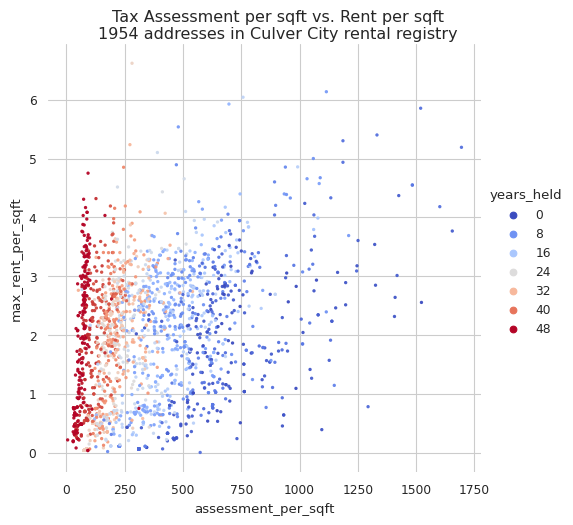

In [89]:
sns.set_theme(style="whitegrid")
sns.set_context("paper")

cmap = sns.color_palette("coolwarm", as_cmap=True)

g = sns.relplot(
    data=dfm,
    x="assessment_per_sqft",
    y="max_rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.95,
    palette=cmap,
    marker=".",
)
g.despine(left=True, bottom=True)
plt.suptitle(
    f"Tax Assessment per sqft vs. Rent per sqft\n{len(dfm)} addresses in Culver City rental registry",
    y=1.04,
)
plt.savefig(
   os.path.join(
       os.environ["HOME"], "ryancompton.net/assets/pix/tax_vs_rent_culver_city.png"
   )
)

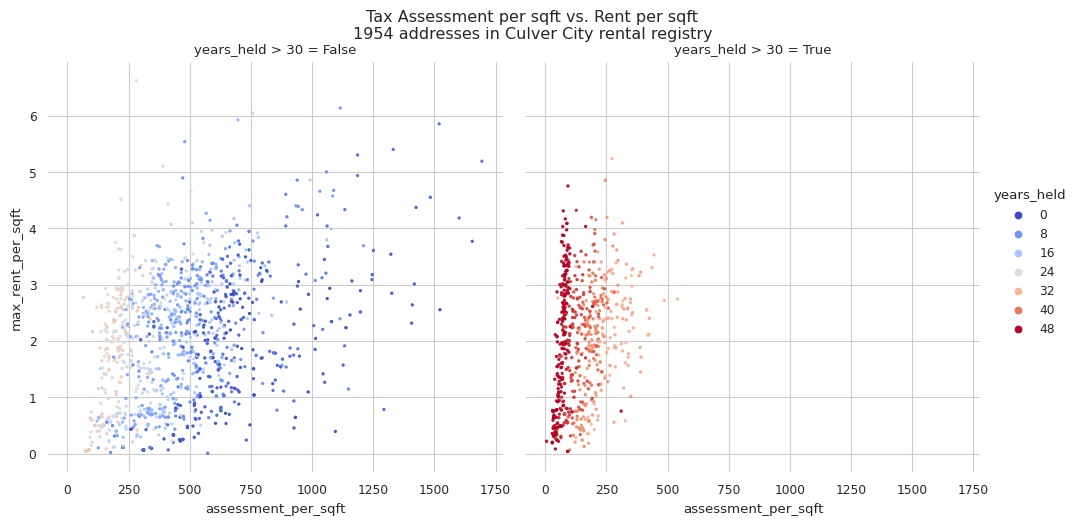

In [88]:
dfm['years_held > 30'] = dfm.years_held > 30
sns.set_theme(style="whitegrid")
sns.set_context("paper")

cmap = sns.color_palette("coolwarm", as_cmap=True)

g = sns.relplot(
    data=dfm,
    x="assessment_per_sqft",
    y="max_rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.95,
    palette=cmap,
    marker=".",
    col='years_held > 30'
)
g.despine(left=True, bottom=True)
plt.suptitle(
    f"Tax Assessment per sqft vs. Rent per sqft\n{len(dfm)} addresses in Culver City rental registry",
    y=1.04,
)
plt.savefig(
   os.path.join(
       os.environ["HOME"], "ryancompton.net/assets/pix/tax_vs_rent_culver_city_split30.png"
   )
)



In [12]:
hex_cmap = sns.color_palette("coolwarm", n_colors=len(set(df.years_held))).as_hex()


def get_color(x):
    for idx, years in enumerate(sorted(set(df.years_held))):
        if x == years:
            return hex_cmap[max(0, idx)]


df["gmap_color"] = df["years_held"].map(get_color)

df["assessment_to_rent_ratio"] = df["assessment_to_rent_ratio"].round(2)
dfp = df[
    [
        "glat",
        "glng",
        "gmap_color",
        "gaddress",
        "current_rent",
        "current_assessment",
        "assessment_to_rent_ratio",
        "BaseValue_Year",
        "lagov",
        "screenshot",
    ]
]
print(dfp.sample(10).to_csv(sep="\t", index=False))

glat	glng	gmap_color	gaddress	current_rent	current_assessment	assessment_to_rent_ratio	BaseValue_Year	lagov	screenshot
34.2988638	-118.4993745	#c32e31	12555 Nedra Dr, Granada Hills, CA 91344, USA	5000.0	159356.0	31.87	1975	https://portal.assessor.lacounty.gov/parceldetail/2609022032	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-06-11/12555_Nedra_Dr,_Granada_Hills,_CA_91344,_USA.png
33.7246828	-118.3176171	#c32e31	2501 Graysby Ave, San Pedro, CA 90732, USA	4650.0	112450.0	24.18	1975	https://portal.assessor.lacounty.gov/parceldetail/7563011017	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-07-07/2501_Graysby_Ave,_San_Pedro,_CA_90732,_USA.png
34.1472542	-118.5885488	#7396f5	4150 Prasa Rd, Woodland Hills, CA 91364, USA	6500.0	594571.0	91.47	2015	https://portal.assessor.lacounty.gov/parceldetail/2172024036	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-05-15/4150_Prasa_Rd,_Woodland_Hills,_CA_91364,_USA.png
33.9799937	-118.29882

In [13]:
dfp.to_csv(
    "/home/ryn/ryancompton.net/assets/taxrentlocations.tsv", sep="\t", index=False
)